In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-04-20 23:35:48,272: Default instance: ibm-q/open/main


In [2]:
!pip install qiskit_machine_learning

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles, make_moons, make_blobs
from ipywidgets import interact, widgets

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

algorithm_globals.random_seed = 42

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Select a dataset:
1. Linearly Separable Dataset
2. Non-linearly Separable Dataset (Circles)
3. Non-linearly Separable Dataset (Moons)
4. Clustering Dataset (Gaussian Blobs)


Enter the number of the dataset you want to visualize:  4


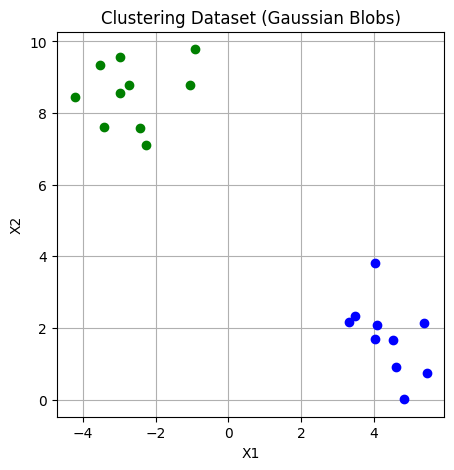

In [120]:
def plot_dataset(X, y, title):
    plt.figure(figsize=(5, 5))
    for x, y_target in zip(X, y):
        if y_target == 1:
            plt.plot(x[0], x[1], "bo")
        else:
            plt.plot(x[0], x[1], "go")
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True)
    plt.show()
    
def select_dataset():
    print("Select a dataset:")
    print("1. Linearly Separable Dataset")
    print("2. Non-linearly Separable Dataset (Circles)")
    print("3. Non-linearly Separable Dataset (Moons)")
    print("4. Clustering Dataset (Gaussian Blobs)")
    choice = input("Enter the number of the dataset you want to visualize: ")
    return int(choice)

def generate_dataset(choice, num_samples=20):
    if choice == 1:
        X = 2 * np.random.random([num_samples, 2]) - 1
        y01 = 1 * (np.sum(X, axis=1) >= 0)
        y = 2 * y01 - 1
    elif choice == 2:
        X, y = make_circles(n_samples=num_samples, noise=0.1, random_state=42, factor=0.5)
        y01 = (y + 1) // 2  # Convert {-1, +1} to {0, 1}
        y = 2 * y01 - 1
    elif choice == 3:
        X, y = make_moons(n_samples=num_samples, noise=0.1, random_state=42)
        y01 = (y + 1) // 2  # Convert {-1, +1} to {0, 1}
        y = 2 * y01 - 1
    elif choice == 4:
        X, y = make_blobs(n_samples=num_samples, centers=2, random_state=42)
        y01 = 1 * (y == 1)
        y = 2 * y01 - 1
    else:
        print("Invalid choice. Please select a valid dataset.")
        return None, None, None
    return X, y, y01

choice = select_dataset()
X, y, y01 = generate_dataset(choice)
if X is not None and y is not None:
    if choice == 1:
        plot_dataset(X, 2 * y - 1, "Linearly Separable Dataset")
    elif choice == 2:
        plot_dataset(X, 2 * (y + 1) // 2 - 1, "Non-linearly Separable Dataset (Circles)")
    elif choice == 3:
        plot_dataset(X, 2 * (y + 1) // 2 - 1, "Non-linearly Separable Dataset (Moons)")
    elif choice == 4:
        plot_dataset(X, 2 * y - 1, "Clustering Dataset (Gaussian Blobs)")

In [121]:
def convert_to_dataframe(X, y, y01):
    df = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'y': y, 'y01': y01})
    return df

df=convert_to_dataframe(X, y, y01)
df

,X1,X2,y,y01
0,-0.929985,9.781721,-1,0
1,-4.234115,8.451999,-1,0
2,-2.978672,9.556846,-1,0
3,4.524231,1.672066,1,1
4,-2.972615,8.548556,-1,0
5,4.848742,0.013500,1,1
6,4.038172,3.825448,1,1
7,-3.522029,9.328533,-1,0
8,4.095496,2.084092,1,1
9,-2.743351,8.780149,-1,0


In [122]:
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

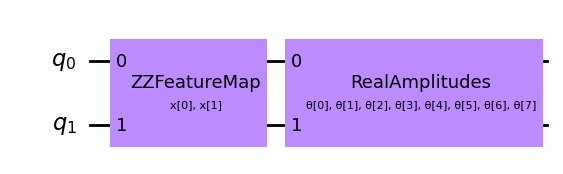

In [123]:
num_inputs = 2
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs)
qc1 = QuantumCircuit(num_inputs)
qc1.compose(feature_map, inplace=True)
qc1.compose(ansatz, inplace=True)
qc1.draw(output="mpl", style="clifford", fold=-1)

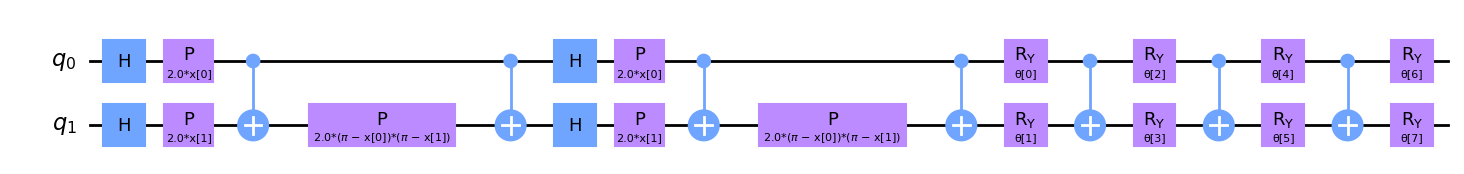

In [124]:
from qiskit import transpile
from qiskit.circuit.library.standard_gates import RXGate, RYGate, RZGate

qc1_rxryrz = qc1.decompose()

qc1_rxryrz.draw(output="mpl", style="clifford", fold=-1)

In [134]:
qnn1 = EstimatorQNN(
    circuit=qc1, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

Initial weights:  [ 0.06383998 -0.08144878 -0.0211037   0.04755951 -0.04850961  0.05046578
  0.00083572  0.0500532 ]


In [135]:
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

model1.train()

def closure():
    optimizer.zero_grad()
    loss = f_loss(model1(X_), y_)
    loss.backward()
    print(loss.item())
    return loss

optimizer.step(closure)

20.34795379638672
17.938724517822266
17.17574691772461
16.399681091308594
18.927196502685547
20.46347427368164
18.115026473999023
18.894834518432617
15.197500228881836
15.027726173400879
15.019021987915039
15.01607894897461
15.015908241271973
15.015854835510254
15.015853881835938
15.015852928161621
15.015853881835938


tensor(20.3480, grad_fn=<MseLossBackward0>)

Accuracy: 0.75


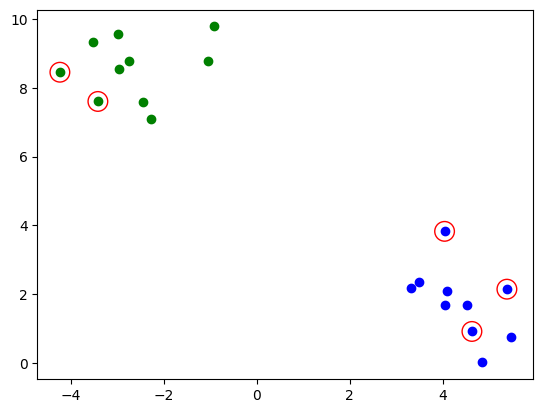

In [136]:
model1.eval()
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y) / len(y))

for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=1)

plt.show()

In [137]:
feature_map2 = ZZFeatureMap(num_inputs)
ansatz2 = RealAmplitudes(num_inputs, entanglement="linear", reps=1)

qc2 = QuantumCircuit(num_inputs)
qc2.compose(feature_map2, inplace=True)
qc2.compose(ansatz2, inplace=True)

parity = lambda x: "{:b}".format(x).count("1") % 2  
output_shape = 2  
qnn2 = SamplerQNN(
    circuit=qc2,
    input_params=feature_map2.parameters,
    weight_params=ansatz2.parameters,
    interpret=parity,
    output_shape=output_shape,
)

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

Initial weights:  [-0.00706407 -0.02641913 -0.05616216 -0.05832413]


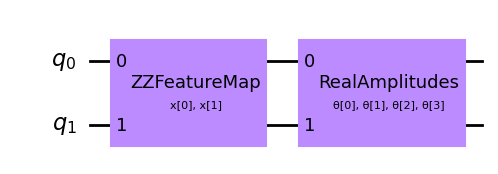

In [138]:
qc2.draw(output="mpl", style="clifford", fold=-1)

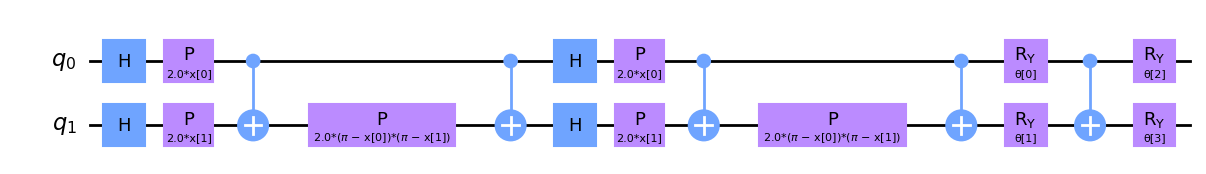

In [139]:
qc2_rxryrz = qc2.decompose()

qc2_rxryrz.draw(output="mpl", style="clifford", fold=-1)

In [140]:
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()  

model2.train()

def closure():
    optimizer.zero_grad(set_to_none=True)  
    loss = f_loss(model2(X_), y01_) 
    loss.backward()  

    print(loss.item())  
    return loss


optimizer.step(closure);

0.773969829082489
0.7635452747344971
0.6289950013160706
0.6647459268569946
0.672054648399353
0.7954845428466797
0.7883034348487854
0.8191760778427124
0.8225563168525696
0.6567259430885315
0.6601770520210266
0.699474036693573
0.7610222101211548
0.7885302305221558
0.6730921268463135
0.73565274477005
0.7481037974357605
0.7248122096061707
0.7301725745201111
0.7032373547554016


Accuracy: 0.55


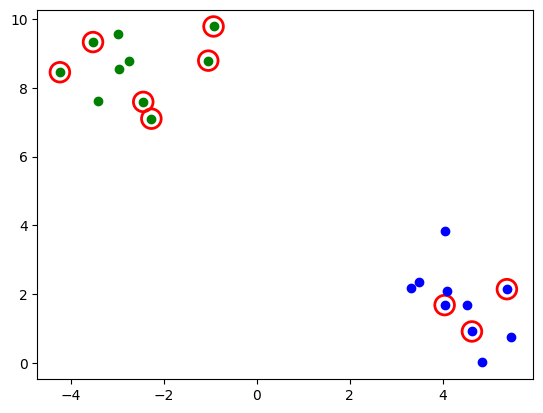

In [141]:
model2.eval()
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print("Accuracy:", sum(y_predict == y01) / len(y01))

for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.show()

Select a function:
1. sin(x)
2. cos(x)
3. tan(x)
4. exp(x)
5. floor(x)


Enter the number of the function you want to use:  5


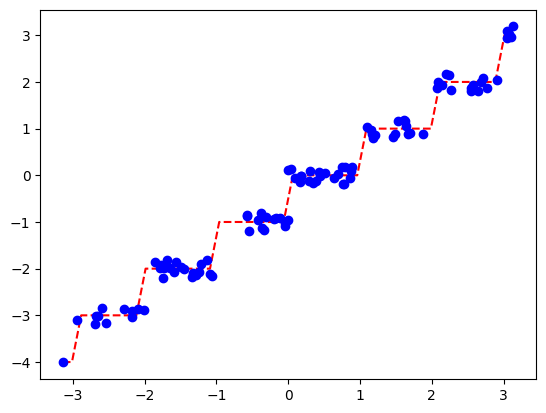

In [160]:
from numpy import sin, cos, tan, exp, floor

num_samples = 100
eps = 0.2
lb, ub = -np.pi, np.pi
print("Select a function:")
print("1. sin(x)")
print("2. cos(x)")
print("3. tan(x)")
print("4. exp(x)")
print("5. floor(x)")
choice = int(input("Enter the number of the function you want to use: "))

if choice == 1:
    f = lambda x: sin(x)
elif choice == 2:
    f = lambda x: cos(x)
elif choice == 3:
    f = lambda x: tan(x)
elif choice == 4:
    f = lambda x: exp(x)
elif choice == 5:
    f = lambda x: floor(x)
else:
    print("Invalid choice. Defaulting to cos(x).")
    f = lambda x: cos(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X) + eps * (2 * algorithm_globals.random.random([num_samples, 1]) - 1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()

In [161]:
param_x = Parameter("x")
feature_map3 = QuantumCircuit(1, name="fm")
feature_map3.ry(param_x, 0)

param_y = Parameter("y")
ansatz3 = QuantumCircuit(1, name="vf")
ansatz3.ry(param_y, 0)

qc3 = QuantumCircuit(1)
qc3.compose(feature_map3, inplace=True)
qc3.compose(ansatz3, inplace=True)

qnn3 = EstimatorQNN(circuit=qc3, input_params=[param_x], weight_params=[param_y])

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

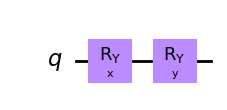

In [162]:
qc3.draw(output="mpl", style="clifford", fold=-1)

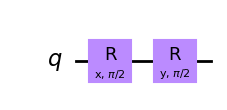

In [163]:
qc3_expanded = qc3.decompose()
qc3_expanded.draw(output="mpl", style="clifford", fold=-1)

In [166]:
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction="sum")

model3.train() 

def closure():
    optimizer.zero_grad(set_to_none=True)  
    loss = f_loss(model3(Tensor(X)), Tensor(y))  
    loss.backward()  
    print(loss.item())  
    return loss

optimizer.step(closure)

177.5814971923828
189.43008422851562
177.58120727539062
177.58119201660156


tensor(177.5815, grad_fn=<MseLossBackward0>)

Mean Squared Error (MSE): 2.423182574836388


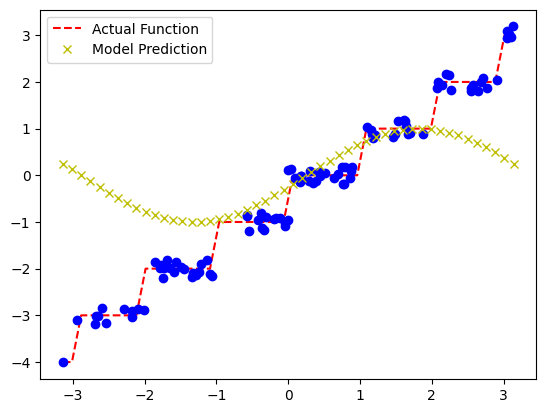

In [167]:
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--", label="Actual Function")

plt.plot(X, y, "bo")

model3.eval()
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "yx", label="Model Prediction")
plt.legend()
mse = np.mean((f(np.linspace(lb, ub)) - np.array(y_)) ** 2)
print("Mean Squared Error (MSE):", mse)
plt.show()